## Trying open source baselines

In [22]:
from semantic_search.utils import load_metadata
from semantic_search.data_retrieval.utils import extract_abstract_from_md

df, ref_df = load_metadata(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)

df.head()
df['abstract'] = df['fpath'].apply(extract_abstract_from_md)
df = df[df.abstract.apply(len) > 0]

In [24]:
df.abstract[0]

'We introduce the Fixed Point Diffusion Model (FPDM), a novel approach to image generation that integrates the concept of fixed point solving into the framework of diffusionbased generative modeling. Our approach embeds an implicit fixed point solving layer into the denoising network of a diffusion model, transforming the diffusion process into a sequence of closely-related fixed point problems. Combined with a new stochastic training method, this approach significantly reduces model size, reduces memory usage, and accelerates training. Moreover, it enables the development of two new techniques to improve sampling efficiency: reallocating computation across timesteps and reusing fixed point solutions between timesteps. We conduct extensive experiments with state-of-the-art models on ImageNet, FFHQ, CelebA-HQ, and LSUN-Church, demonstrating substantial improvements in performance and efficiency. Compared to the state-of-the-art DiT model [38], FPDM contains 87% fewer parameters, consume

In [34]:
import os, requests

API_KEY = os.getenv("SEMANTIC_SCHOLAR_API_KEY")
SEMSCHOL_URL = "https://api.semanticscholar.org/graph/v1/paper/search"
OPENALEX_URL = "https://api.openalex.org/works"
CORE_URL = "https://api.core.ac.uk/v3/search/works"

def semschol_search(query: str, limit: int = 5):
    resp = requests.get(
        SEMSCHOL_URL,
        params={
            "query": query,
            "fields": "title,abstract,year,authors,url",
            "limit": limit
        },
        headers={"x-api-key": API_KEY} if API_KEY else {}
    )
    resp.raise_for_status()
    return resp.json().get("data", [])


OPENALEX_EMAIL = os.getenv("OPENALEX_EMAIL")  # e.g. "yourname@example.com"

def openalex_search(query: str, per_page: int = 5):
    params = {
        "search": query,
        "per-page": per_page
    }
    if OPENALEX_EMAIL:
        params["mailto"] = OPENALEX_EMAIL
    resp = requests.get(OPENALEX_URL, params=params)
    resp.raise_for_status()
    return resp.json().get("results", [])


API_KEY  = os.getenv("CORE_API_KEY")  # set this to your CORE API key

def core_search(query: str, page_size: int = 5):
    headers = {"Authorization": f"Bearer {API_KEY}"} if API_KEY else {}
    params  = {"q": query, "pageSize": page_size}
    r = requests.get(CORE_URL, params=params, headers=headers)
    r.raise_for_status()
    return r.json().get("data", [])

query = [df.abstract[0][:100], "Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously."][1]
# semschol_search(query)
semschol_search(query), openalex_search(query), core_search(query)

HTTPError: 500 Server Error: Internal Server Error for url: https://api.core.ac.uk/v3/search/works/?q=Deeper+neural+networks+are+more+difficult+to+train.+We+present+a+residual+learning+framework+to+ease+the+training+of+networks+that+are+substantially+deeper+than+those+used+previously.&pageSize=5

## Core and referenced paper stats

In [43]:
df, ref_df = load_metadata(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)

In [38]:
df.head()

,fpath,fname,title,oaid,oa_doi,oa_sim_score_1st,oa_sim_score_2nd,oa_ref_cnt,oa_refs_oaid,ssid,ss_doi,ss_sim_score,ss_ref_cnt,ss_refs_ssid,ss_refs_doi,refs_oaids_from_dois,refs_dois_from_oaids,ref_jaccard
0,/cluster/home/lcarretero/workspace/dsl/dsl-res...,Bai_Fixed_Point_Diffusion_Models_CVPR_2024_pap...,Fixed Point Diffusion Models,W4402774861,10.1109/cvpr52733.2024.00901,1.0,1.000000,0.0,[],fdb679246a2125dad1628081e45efb7a1c80f2c7,10.1109/CVPR52733.2024.00901,1.0,56.0,"[9b91b3031ea159e4964d18b2ce703168660ecf46, 0e8...","[10.48550/arXiv.2401.11605, 10.48550/arXiv.240...","[w4385245566, w2108598243, w3094502228, w43129...",[],NaN
1,/cluster/home/lcarretero/workspace/dsl/dsl-res...,Li_BEVNeXt_Reviving_Dense_BEV_Frameworks_for_3...,BEVNeXt: Reviving Dense BEV Frameworks for 3D ...,W4402727763,10.1109/cvpr52733.2024.01901,1.0,1.000000,73.0,"[W1861492603, W2083047701, W2108598243, W21245...",a23f6180d6908499a8238c06f4fb57bf431a2b43,10.1109/CVPR52733.2024.01901,1.0,70.0,"[02882d2dc6e3938a327a66663e55339190784534, 93c...","[10.48550/arXiv.2310.15670, 10.48550/arXiv.230...","[w2194775991, w4385245566, w2108598243, w18614...","[10.1109/cvpr.2016.90, 10.48550/arxiv.1706.037...",0.762619
2,/cluster/home/lcarretero/workspace/dsl/dsl-res...,Savchenko_Leveraging_Pre-trained_Multi-task_De...,Leveraging Pre-trained Multi-task Deep Models ...,W4402916217,10.1109/cvprw63382.2024.00473,1.0,0.000000,0.0,[],9c50996ba35eb605cb9bcd5835103b441cf38e07,10.1109/CVPRW63382.2024.00473,1.0,57.0,"[9a70cc28d1475665c1d3f0aa76ae9c962d9109d5, 63d...","[10.1109/CVPRW63382.2024.00483, 10.48550/arXiv...","[w4286910290, w4288327876, w2713788831, w29819...",[],NaN
3,/cluster/home/lcarretero/workspace/dsl/dsl-res...,Geada_Insights_from_the_Use_of_Previously_Unse...,Insights from the Use of Previously Unseen Neu...,W4402727561,10.1109/cvpr52733.2024.02127,1.0,0.987342,23.0,"[W1686810756, W2097117768, W2108598243, W21515...",a494cfa653ae449019ffe8c8908bfec8042218d2,10.1109/CVPR52733.2024.02127,1.0,38.0,"[48af7a849d063f9e7771eba585e01b0f49dcb26b, 5a9...","[10.1016/s0262-4079(24)01566-5, 10.48550/arXiv...","[w2194775991, w2108598243, w2963446712, w30945...","[10.1109/cvpr.2016.90, nan, 10.1109/cvpr.2009....",0.448611
4,/cluster/home/lcarretero/workspace/dsl/dsl-res...,Khairi_Efficient_Local_Correlation_Volume_for_...,Efficient local correlation volume for unsuper...,W4402904316,10.1109/cvprw63382.2024.00049,1.0,0.000000,28.0,"[W1513100184, W1578285471, W1867429401, W19931...",1bede9c7617eda6d635114c0ebf9c621f96e6485,10.1109/CVPRW63382.2024.00049,1.0,29.0,"[c4c04e3aa4f60f0dd3c29b463890cf5610497d23, 50c...","[10.1016/j.jag.2023.103543, 10.1109/ICCV51070....","[w2133665775, w1867429401, w1513100184, w20596...","[10.1109/tip.2003.819861, 10.1016/0004-3702(81...",0.656863


In [41]:
df.ss_ref_cnt.sum(), df.oa_ref_cnt.sum()

(60944.0, 25938.0)

(25061, 10)


/scratch/tmp.30933079.lcarretero/ipykernel_225165/3825937339.py:23: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


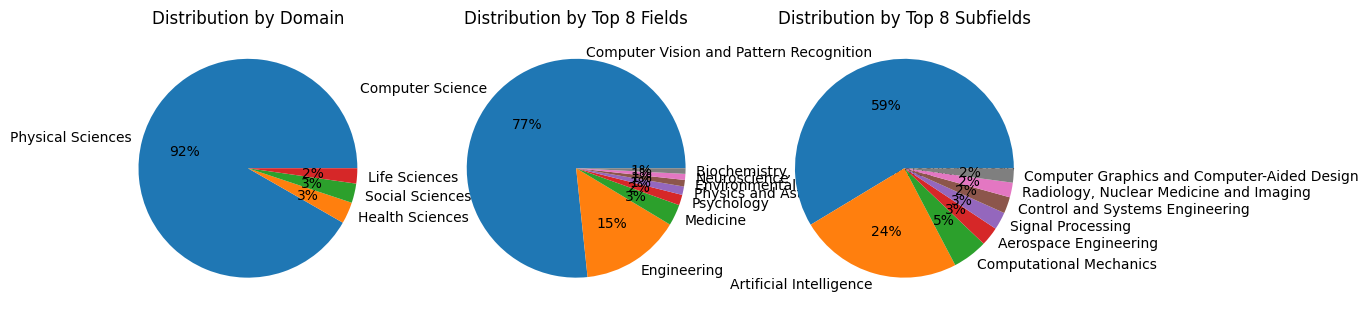

,oaid,doi,ref_via,title,abstract,type,topic,domain,field,subfield
0,W2194775991,10.1109/cvpr.2016.90,openalex_id,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,article,Advanced Neural Network Applications,Physical Sciences,Computer Science,Computer Vision and Pattern Recognition
1,W1686810756,NaN,openalex_id,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of the ...,article,Advanced Vision and Imaging,Physical Sciences,Computer Science,Computer Vision and Pattern Recognition
2,W4385245566,10.48550/arxiv.1706.03762,openalex_id,Attention Is All You Need,The dominant sequence transduction models are ...,preprint,Natural Language Processing Techniques,Physical Sciences,Computer Science,Artificial Intelligence
3,W2108598243,10.1109/cvpr.2009.5206848,openalex_id,ImageNet: A large-scale hierarchical image dat...,The explosion of image data on the Internet ha...,article,Advanced Image and Video Retrieval Techniques,Physical Sciences,Computer Science,Computer Vision and Pattern Recognition
4,W2133665775,10.1109/tip.2003.819861,openalex_id,Image Quality Assessment: From Error Visibilit...,Objective methods for assessing perceptual ima...,article,Image and Video Quality Assessment,Physical Sciences,Computer Science,Computer Vision and Pattern Recognition


In [52]:
print(ref_df.shape)
# Create pie charts for field, domain, and subfield distributions
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Domain distribution
domain_counts = ref_df['domain'].value_counts()
axes[0].pie(domain_counts, labels=domain_counts.index, autopct='%1.0f%%')
axes[0].set_title('Distribution by Domain')

# Field distribution
field_counts = ref_df['field'].value_counts().head(8)
axes[1].pie(field_counts, labels=field_counts.index, autopct='%1.0f%%')
axes[1].set_title('Distribution by Top 8 Fields')

# Subfield distribution (showing top 10 for readability)
subfield_counts = ref_df['subfield'].value_counts().head(8)
axes[2].pie(subfield_counts, labels=subfield_counts.index, autopct='%1.0f%%')
axes[2].set_title('Distribution by Top 8 Subfields')

plt.tight_layout()
plt.show()

# Display the dataframe head as well
ref_df.head()

In [ ]:
scp -r lcarretero@euler.ethz.ch:/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3 /Users/luis/Desktop/tmp

In [54]:
import numpy as np
fpath = r'/Users/luis/Desktop/ETH/Courses/SS25-DSL/db/allenai_specter2/embeddings.npy'
arr = np.load(fpath)
arr.shape


(25526, 384)

## Visualize latent space

In [56]:
from semantic_search.store import milvus_store
reload(milvus_store)

<module 'semantic_search.store.milvus_store' from '/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/store/milvus_store.py'>

In [70]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from semantic_search.store.milvus_store import MilvusDocumentStore


ds = MilvusDocumentStore()
ds.load_store(db_superdir='/Users/luis/Desktop/ETH/Courses/SS25-DSL/db', store_name='mini_gte')

max_n = 10000
embeddings = ds.embeddings[:max_n, :]
docs = ds.document_store[:max_n]

# Apply SVD to reduce dimensions to 50 (or another appropriate value)
svd = TruncatedSVD(n_components=32, random_state=42)
embeddings_svd = svd.fit_transform(embeddings)

# Then apply t-SNE on the SVD-reduced embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_svd)

Using device: mps
Loaded store from /Users/luis/Desktop/ETH/Courses/SS25-DSL/db/mini_gte


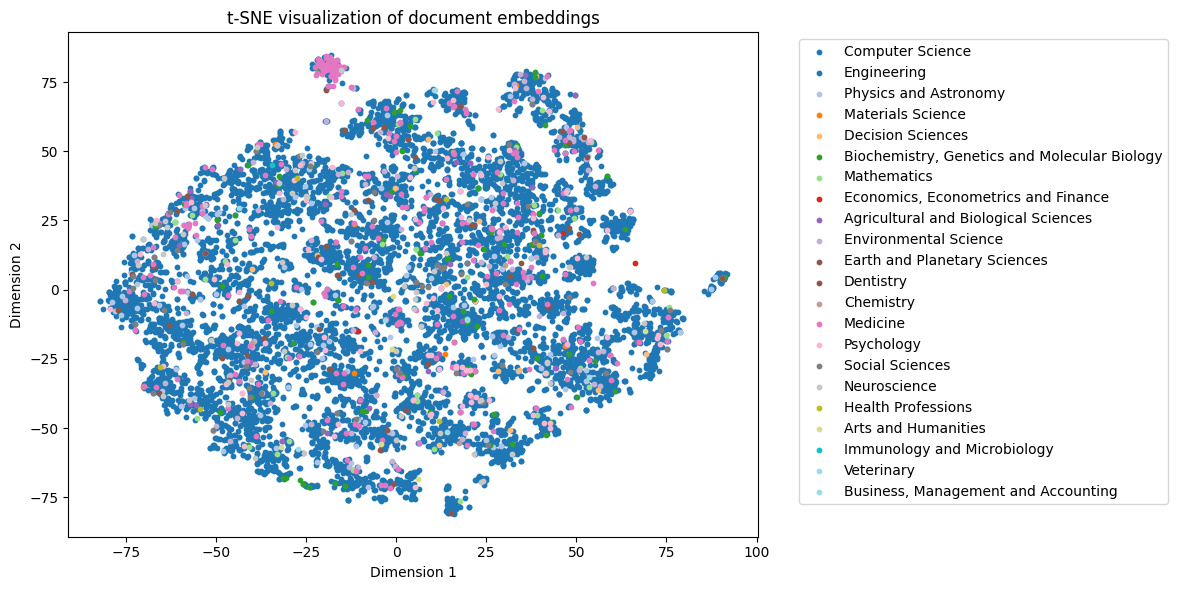

In [71]:
# Plot the embeddings
cat = docs['field']  # topic, subfield, domain

# Get unique categories and create a colormap
unique_categories = cat.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_categories)))
color_dict = dict(zip(unique_categories, colors))

plt.figure(figsize=(12, 6))
for category, color in color_dict.items():
    mask = cat == category
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                color=color, alpha=1, s=10, label=category)
    
plt.title('t-SNE visualization of document embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Related work - abstract prediction benchmark dev

In [ ]:
def extract_citation_order(paper_ref_dict:dict):
    related_work = paper_ref_dict["related_work"]
    citations = re.findall(r"\[[0-9, ]+\]", related_work)
    in_text_ref_dict_order = []
    for citation in citations:
        temp = ast.literal_eval(citation)
        in_text_ref_dict_order_i = []
        for i in temp:
            if int(i) in paper_ref_dict["rw_in_text_ref_nums"]:
                in_text_ref_dict_order_i.append(int(i))
        #in_text_ref_dict_order_i = [int(i) for i in in_text_ref_dict_order_i]
        in_text_ref_dict_order.append(in_text_ref_dict_order_i)
    return in_text_ref_dict_order

In [2]:
import sys
sys.path.append('/Users/luis/Desktop/ETH/Courses/SS25-DSL/src')

In [6]:
from importlib import reload
from semantic_search import utils
reload(utils)

<module 'semantic_search.utils' from '/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/utils.py'>

In [7]:
from semantic_search.utils import load_data

df, ref_df = load_data(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)

In [8]:
df['fpath'][0]

'Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/Conversions/opencvf-data/txt/Bai_Fixed_Point_Diffusion_Models_CVPR_2024_paper.txt'

#### Paper sections

In [36]:
from pathlib import Path
import re
import pandas as pd
import numpy as np

data = []
for fpath in Path('/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/Conversions/opencvf-data/txt').glob('*.txt'):
    # Read the file and extract headings
    with open(fpath, 'r') as f:
        content = f.read()
    
    # Look for headings that start with ## 
    # Match headings that start with ## followed by a number but not subheadings with decimal points
    headings = re.findall(r'## (\d+\.[^.\d][^\n]+)', content)  # Match main sections like "1. Introduction" but not "1.1. Background"

    data.append({
        'file': fpath.name,
        'headings': [title[3:] for title in headings]
    })
df2 = pd.DataFrame(data)

In [46]:
pd.Series(np.concatenate(df2.headings.values)).value_counts().head(10)

Introduction     1130
Conclusion        826
Related Work      686
Experiments       669
Method            340
Methodology       185
Related Works     157
Related work      118
Conclusions       109
Results            84
Name: count, dtype: int64

In [53]:
def contains_section(headings: list, section_name: str) -> bool:
    return section_name in headings

(df2.headings.apply(lambda x: 'Experiments' in x).value_counts()/len(df2)*100).round(1)

headings
True     58.6
False    41.4
Name: count, dtype: float64